<Axes: title={'center': 'Adguard filter list popularity'}, xlabel='name'>

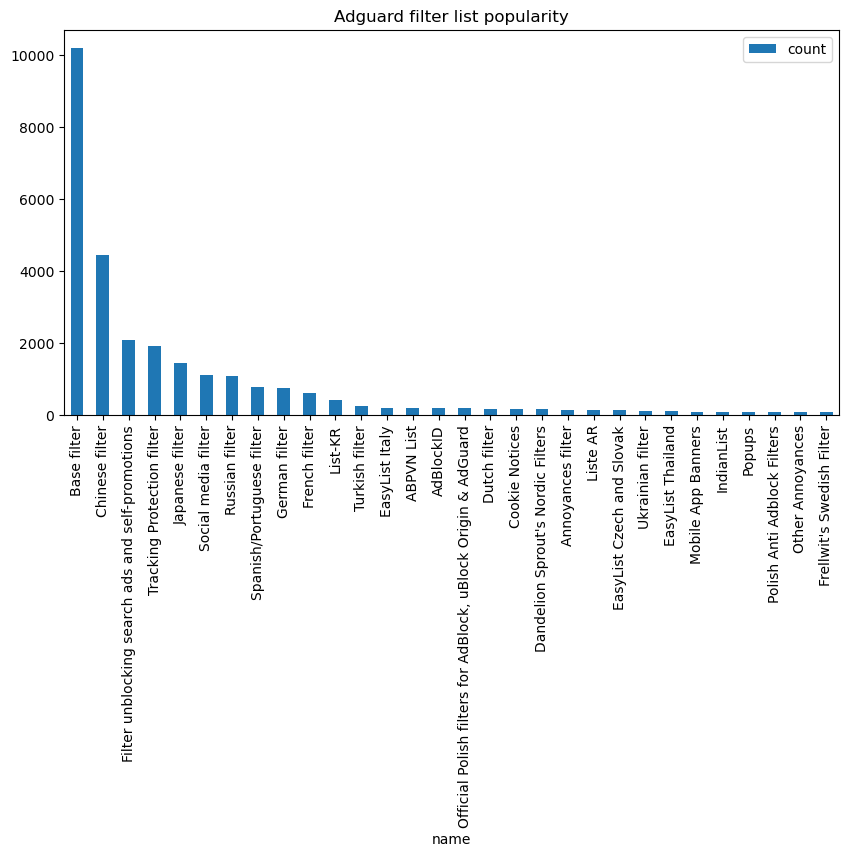

In [7]:
import pandas as pd
import json
import os
import sys
sys.path.append('..')
from pathlib import Path
import yaml

ADGUARD_POPULARITY_FP = Path("statistics_from_adblockers/adguard_fl_popularity.csv")
ADGUARD_METADATA_FP = Path("statistics_from_adblockers/adguard_fl_metadata.json")
ADGUARD_PROJECT_METADATA_FP = Path("../conf/filterlists/adguard.yaml")

# load data
adguard_popularity = pd.read_csv(ADGUARD_POPULARITY_FP)
adguard_metadata = json.load(open(ADGUARD_METADATA_FP))
adguard_project_metadata = yaml.safe_load(open(ADGUARD_PROJECT_METADATA_FP))['list']
adguard_metadata_df= pd.DataFrame(adguard_metadata['filters'])
adguard_popularity = adguard_popularity.merge(adguard_metadata_df, left_on='list_id', right_on='filterId')

# remove the word filter if it occurs in the end of the name
adguard_popularity['name'] = adguard_popularity['name'].apply(lambda x: x[:-6] if x.endswith(' filter') else x)

# for each name replace it with original if it is an alias
def normalize_name(name):
    for filter in adguard_project_metadata:
        if name.strip()  == filter['name']:
            return name
        if name.strip() in filter.get('aliases', []):
            return filter['name']
        
    return name

adguard_popularity['name'] = adguard_popularity['name'].apply(normalize_name)

adguard_popularity = adguard_popularity[['list_id', 'name', 'count']]

# only keep top 30

adguard_popularity.sort_values(by='count', ascending=False).head(30).plot.bar(x='name', y='count', figsize=(10, 5), title='Adguard filter list popularity')

In [16]:
default_lists =  yaml.safe_load(open(ADGUARD_PROJECT_METADATA_FP))['default']
language_specific_filters = [
    "Chinese filter",
    "Japanese filter",
    "Russian filter",
    "Spanish/Portuguese filter",
    "German filter",
    "French filter",
    "List-KR",  # Korean filter
    "Turkish filter",
    "EasyList Italy",
    "ABPVN List",  # Vietnamese filter
    "AdBlockID",  # Indonesian filter
    "Official Polish filters for AdBlock, uBlock Origin & AdGuard",
    "Dutch filter",
    "Liste AR",  # Arabic filter
    "EasyList Czech and Slovak",
    "Ukrainian filter",
    "EasyList Thailand",
    "IndianList",
    "Polish Anti Adblock Filters",
    "Frellwit's Swedish Filter",
    "Bulgarian list",
    "Adblock List for Finland",
    "Hungarian filter",
    "Persian Blocker",
    "EasyList Hebrew",
    "EasyList China",
    "Estonian List",
    "EasyList Lithuania",
    "Latvian List",
    "Macedonian adBlock Filters",
    "YousList",  # Korean filter
    "EasyList Polish",
    "Greek AdBlock Filter",
    "ROList"  # Romanian filter
]

# sum rows where name not in default lists
print(adguard_popularity[~adguard_popularity['name'].isin(default_lists)]['count'].max())
print(adguard_popularity[~adguard_popularity['name'].isin(default_lists + language_specific_filters)]['count'].max())
print(adguard_popularity[adguard_popularity['name'].isin(default_lists)]['count'].sum())

print(adguard_popularity.name.to_list())

4449
1907
12272
['Base filter', 'Chinese filter', 'Filter unblocking search ads and self-promotions', 'Tracking Protection filter', 'Japanese filter', 'Social media filter', 'Russian filter', 'Spanish/Portuguese filter', 'German filter', 'French filter', 'List-KR', 'Turkish filter', 'EasyList Italy', 'ABPVN List', 'AdBlockID', 'Official Polish filters for AdBlock, uBlock Origin & AdGuard', 'Dutch filter', 'Cookie Notices', "Dandelion Sprout's Nordic Filters", 'Annoyances filter', 'Liste AR', 'EasyList Czech and Slovak', 'Ukrainian filter', 'EasyList Thailand', 'Mobile App Banners', 'IndianList', 'Popups', 'Polish Anti Adblock Filters', 'Other Annoyances', "Frellwit's Swedish Filter", 'Bulgarian list', 'Adblock List for Finland', 'Widgets', 'URL Tracking filter', "Dandelion Sprout's Serbo-Croatian List", 'Hungarian filter', 'Online Malicious URL Blocklist', 'Persian Blocker', 'EasyList Hebrew', 'EasyList China', 'Estonian List', 'EasyList Lithuania', 'Latvian List', 'Macedonian adBlock 

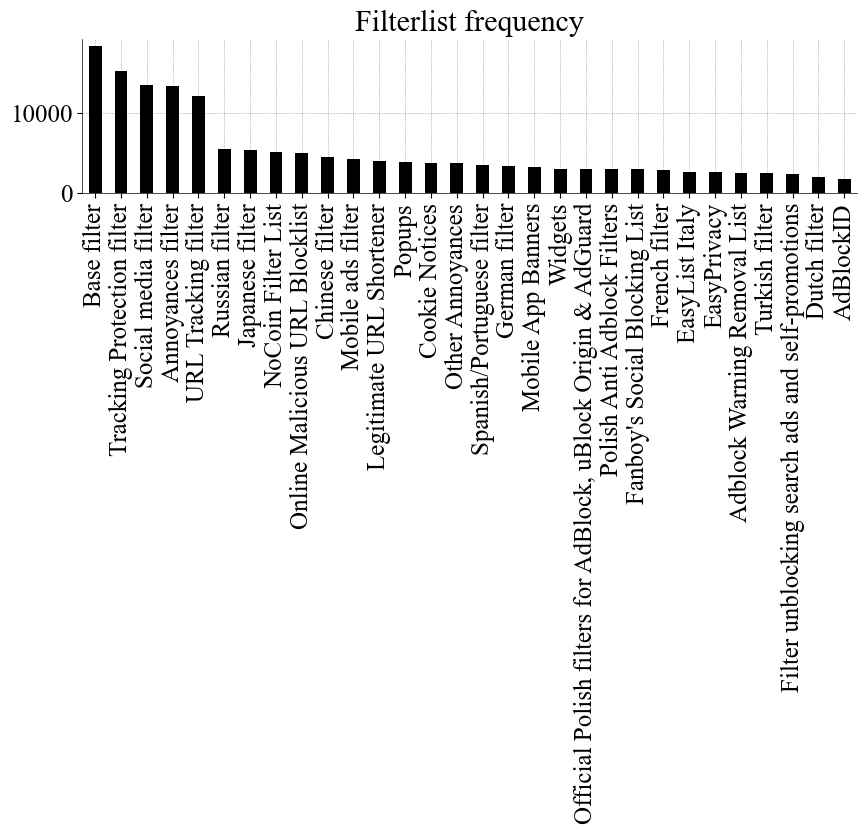

In [78]:
import stats
from importlib import reload
reload(stats)

ISSUES_DIR = Path('../data/issues/').resolve()
ADGUARD_CONFS_DIR = ISSUES_DIR / "adguard/2024-04-24/issues_confs.csv"

forum_users_choices = pd.read_csv(ADGUARD_CONFS_DIR)

_, _, forum_adguard_popularity = stats.filterlist_individual_statistics(forum_users_choices, top_k=30, figsize=(10,2), list_info_metadata=adguard_project_metadata)
forum_adguard_popularity = forum_adguard_popularity.reset_index().rename(columns={'index': 'name'})

In [105]:


# Jaccard similarity between indeces
global_lists_top_30 = set(adguard_popularity.sort_values(by='count', ascending=False).head(30)['name'])
forum_lists_top_30 = set(forum_adguard_popularity.sort_values(by='count', ascending=False).head(30)['name'])

jaccard = len(global_lists_top_30.intersection(forum_lists_top_30)) / len(global_lists_top_30.union(forum_lists_top_30))

print(f"Jaccard similarity between global and forum lists: {jaccard}")

print(f"Global lists: {len(adguard_popularity)}")
print(f"Forum lists: {len(forum_adguard_popularity)}")
print(f"Forum lists: {len(set(forum_adguard_popularity.name))}")

# RBO similarity between indeces

import rbo

def rbo_similarity(list1, list2, p=0.9):
    
    return rbo.RankingSimilarity(list1, list2).rbo_ext()

rbo_res = rbo_similarity(adguard_popularity['name'].tolist(), forum_adguard_popularity['name'].tolist())
print(f"RBO similarity between global and forum lists: {rbo_res}")

# compute earth mover distance between the two distributions

frequencies_global = adguard_popularity.set_index('name')['count']
frequencies_forum = forum_adguard_popularity.set_index('name')['count']

# have the same index for both
frequencies_forum = frequencies_forum.reindex(frequencies_global.index, fill_value=0)
frequencies_global = frequencies_global.reindex(frequencies_forum.index, fill_value=0)


# normalize to become probabilities
frequencies_global = frequencies_global / frequencies_global.sum()
frequencies_forum = frequencies_forum / frequencies_forum.sum()

from scipy.stats import wasserstein_distance

emd = wasserstein_distance(frequencies_global, frequencies_forum)

print(f"Earth mover distance between global and forum lists: {emd}")

Jaccard similarity between global and forum lists: 0.5384615384615384
Global lists: 75
Forum lists: 86
Forum lists: 86
RBO similarity between global and forum lists: 0.7057153750436294
Earth mover distance between global and forum lists: 0.009511531406408742


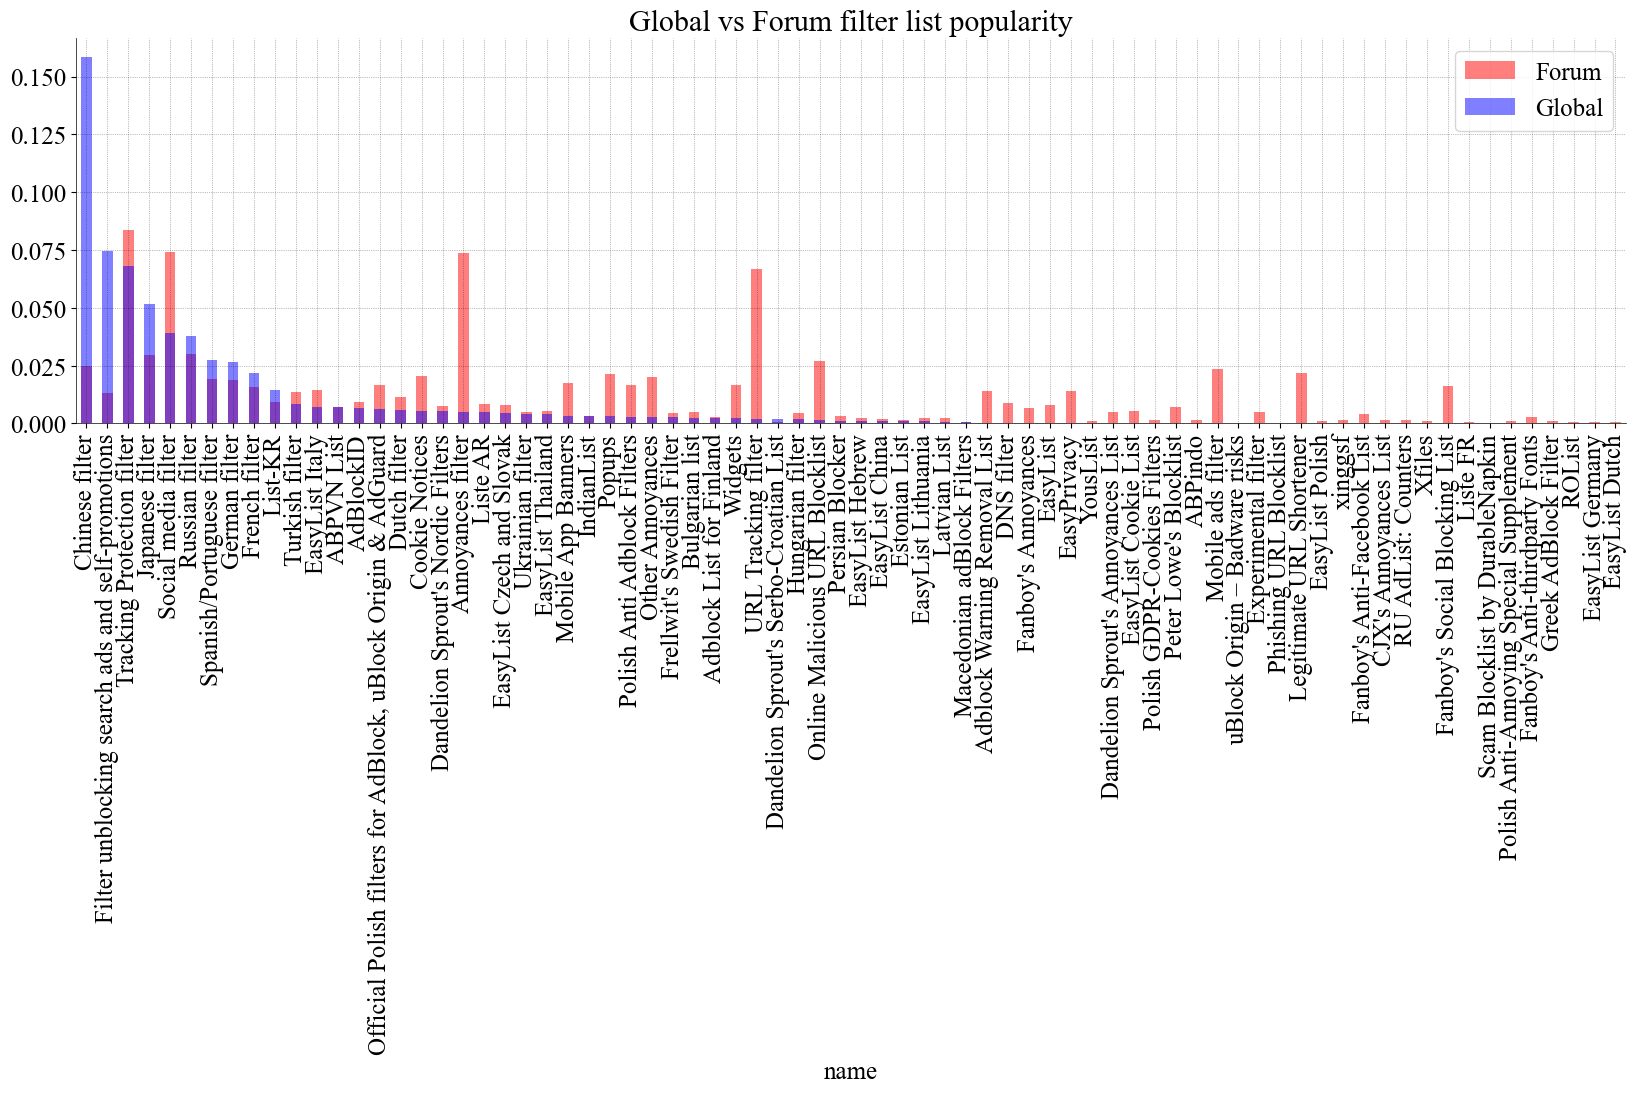

In [106]:
# plotting the frequencies of the two distributions in the same bar plot

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20, 5))

# drop Base filter

_frequencies_forum = frequencies_forum.drop('Base filter')
_frequencies_global = frequencies_global.drop('Base filter')

# frequencies_forum[:30].plot.bar(ax=ax, color='red', alpha=0.5, label='Forum')
# frequencies_global[:30].plot.bar(ax=ax, color='blue', alpha=0.5, label='Global')

_frequencies_forum.plot.bar(ax=ax, color='red', alpha=0.5, label='Forum')
_frequencies_global.plot.bar(ax=ax, color='blue', alpha=0.5, label='Global')

plt.legend()
plt.title('Global vs Forum filter list popularity')
plt.show()

